In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')

In [21]:
def getExamplesDf(path):
    df = pd.read_csv(filepath_or_buffer=path, header=None)
    df['id'] = df.index
    df['class'] = df[22]
    return df
examplesDf = getExamplesDf('../../datasets/test.csv')
examplesSize = examplesDf.shape[0]
# examplesDf

In [22]:
def getMatchesDf(path):
    df = pd.read_csv(filepath_or_buffer=path)
    df['id'] = df['#pointId'].astype(int)
    return df;
mfogDF = getMatchesDf('../../out/matches.csv')
minasDF = getMatchesDf('../../out/minas-og/2020-07-20T18-36-59.803/matches.csv')
# matchesDf

In [23]:
def getOriginalMatchesDf(path):
    df = pd.read_table(filepath_or_buffer=path, header=None)
    df.columns=['id', 'class', 'label']
    df = df[df['id'].str.startswith('Ex:')]
    def cleanLabel(text):
        label = text.replace('Classe MINAS:', '').strip()
        if label == 'Unk': return '-'
        if label.startswith('C '): return label.replace('C ', '')
        return label
    return pd.DataFrame({
        'id': df['id'].apply(lambda x: x.replace('Ex:', '').strip()).astype(int) - 1,
        'label': df['label'].apply(cleanLabel),
    })
ogdf = getOriginalMatchesDf('../../out/minas-og/2020-07-20T12-21-54.755/results')
# print(ogdf['label'].unique())
# ogdf

In [24]:
def merge(exDf, maDf):
    def checkCols(df, cols):
        return pd.Series(cols).isin(df.columns).all()
    assert checkCols(exDf, ['id', 'class'])
    assert checkCols(maDf, ['id', 'label'])
    return pd.merge(exDf[['id', 'class']], maDf[['id', 'label']], on='id', how='left')
def confusionMatrix(exDf, maDf=None):
    merged = exDf
    if maDf is not None:
        merged = merge(exDf, maDf)
    assert merged.columns.all(['id', 'class', 'label'])
    return pd.crosstab(merged['class'], merged['label'],
                       rownames=['Classes (act)'], colnames=['Labels (pred)']).transpose()
confusionMatrix(examplesDf, mfogDF)

Classes (act),A,N
Labels (pred),,
-,18289,323
N,428890,205955


In [25]:
def printEval(exDf, maDf):
    print("examples ", exDf.shape)
    print("matches  ", maDf.shape)
    df = merge(exDf, maDf)
    cf = confusionMatrix(df)
    cf['assinged class'] = cf.idxmax(axis=1)
    cf['max'] = cf[cf.columns].max(axis=1)
    print("Confusion Matrix")
    print(cf)
    
    totalExamples = exDf['id'].count()
    totalMatches = maDf.shape[0]
    tot = max(totalMatches, totalExamples)
    hits = df[df['label'] == df["class"]]['id'].count()
    misses = df[df['label'] != df["class"]]['id'].count()

    print('Total examples   %8d' % (totalExamples))
    print('Total matches    %8d' % (totalMatches))
    print('Hits             %8d (%10f%%)' % (hits, (hits/tot) * 100.0))
    print('Misses           %8d (%10f%%)' % (misses, (misses/tot) * 100.0))
    print('Hits + Misses    %8d (%10f%%)' % (hits + misses, ((hits + misses)/tot) * 100.0))
    print('')
    return cf
# printEval(examplesDf, matchesDf)
# printEval(examplesDf, ogdf)
# printEval(examplesDf, ogndDf)

In [32]:
def diffMinasMfog(examplesDf, minasDF, mfogDF):
    print("\tMinas")
    printEval(examplesDf, minasDF)
    print("\n\tMfog")
    printEval(examplesDf, mfogDF)
    m = pd.merge(minasDF, mfogDF, on='id', how='left')#[['id', 'og', 'label']]
    diff = m[m['label_x'] != m['label_y']]
    toRename = {'clusterLabel_x': 'j_clL', 'clusterRadius_x': 'j_clR',
                'label_x': 'j_L', 'distance_x': 'j_D',
                'clusterLabel_y': 'c_clL', 'clusterRadius_y': 'c_clR',
                'label_y': 'c_L', 'distance_y': 'c_D'}
    toKeep = ['id', 'j_clL', 'j_clR', 'j_L', 'j_D', 'c_clL', 'c_clR', 'c_L', 'c_D']
    print("\n\tDiff")
    print(diff.rename(columns=toRename)[toKeep])
    return diff
mfogDF = getMatchesDf('../../out/matches.csv')
diffMinasMfog(examplesDf, minasDF, mfogDF)

	Minas
examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assinged class     max
Labels (pred)                                       
-               19677     340              A   19677
N              427502  205938              A  427502
Total examples     653457
Total matches      653457
Hits               205938 ( 31.515157%)
Misses             447519 ( 68.484843%)
Hits + Misses      653457 (100.000000%)


	Mfog
examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assinged class     max
Labels (pred)                                       
-               18424     344              A   18424
N              428755  205934              A  428755
Total examples     653457
Total matches      653457
Hits               205934 ( 31.514545%)
Misses             447523 ( 68.485455%)
Hits + Misses      653457 (100.000000%)


	Diff
            id j_clL    j_clR j_L       j_D c_clL     c_clR c_L       c_D
88         

,#pointId_x,clusterLabel_x,clusterCategory_x,clusterId_x,clusterRadius_x,label_x,distance_x,secondDistance_x,id,#pointId_y,clusterLabel_y,clusterCategory_y,clusterId_y,clusterRadius_y,label_y,distance_y,secondDistance_y
88,88,N,normal,0,1.02634,-,1.105216,1.250370,88,88,N,n,19,1.453797,N,1.105437,1.738522
286,286,N,normal,0,1.02634,-,1.097748,1.225880,286,286,N,n,19,1.453797,N,1.097847,1.721652
410,410,N,normal,0,1.02634,-,1.083439,1.212726,410,410,N,n,19,1.453797,N,1.083677,1.650951
539,539,N,normal,0,1.02634,-,1.085700,1.235717,539,539,N,n,19,1.453797,N,1.086120,1.652822
723,723,N,normal,0,1.02634,-,1.086764,1.216089,723,723,N,n,19,1.453797,N,1.086905,1.695172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652439,652439,N,normal,0,1.02634,-,1.073879,1.210125,652439,652439,N,n,19,1.453797,N,1.074178,1.648855
652441,652441,N,normal,0,1.02634,-,1.074051,1.209974,652441,652441,N,n,19,1.453797,N,1.074350,1.648788
652442,652442,N,normal,0,1.02634,-,1.074049,1.209979,652442,652442,N,n,19,1.453797,N,1.074348,1.648790
652681,652681,N,normal,0,1.02634,-,1.080975,1.212575,652681,652681,N,n,19,1.453797,N,1.081161,1.678787


In [27]:
mfogSerialDF = getMatchesDf('../../out/serial.csv')
diffMinasMfog(examplesDf, minasDF, mfogSerialDF)

	Minas
examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assinged class     max
Labels (pred)                                       
-               19677     340              A   19677
N              427502  205938              A  427502
Total examples     653457
Total matches      653457
Hits               205938 ( 31.515157%)
Misses             447519 ( 68.484843%)
Hits + Misses      653457 (100.000000%)


	Mfog
examples  (653457, 25)
matches   (653457, 9)
Confusion Matrix
Classes (act)       A       N assinged class     max
Labels (pred)                                       
-               19677     340              A   19677
N              427502  205938              A  427502
Total examples     653457
Total matches      653457
Hits               205938 ( 31.515157%)
Misses             447519 ( 68.484843%)
Hits + Misses      653457 (100.000000%)


	Diff
Empty DataFrame
Columns: [id, j_clL, j_clR, j_L, j_D, c_clL, c_clR, c_L, c_D]
Index: 

,#pointId_x,clusterLabel_x,clusterCategory_x,clusterId_x,clusterRadius_x,label_x,distance_x,secondDistance_x,id,#pointId_y,clusterLabel_y,clusterCategory_y,clusterId_y,clusterRadius_y,label_y,distance_y,secondDistance_y


In [44]:
def getModelDf(path):
    df = pd.read_csv(filepath_or_buffer=path)
    df['id'] = df['#id'].astype(int)
    toDrop = ['#id', 'label', 'category', 'matches', 'time', 'id'] #+ ['meanDistance', 'radius']
    return df.drop(toDrop, axis=1)#.sort_values('meanDistance')
modelDF = getModelDf('../../datasets/model-clean.csv')
minasFiModDF = getModelDf('../../out/minas-og/2020-07-20T18-36-59.803/model/653457_final.csv')
mfogModelDF = getModelDf('../../out/model.csv')
modelDF

,meanDistance,radius,c0,c1,c2,c3,c4,c5,c6,c7,...,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21
0,0.045530,0.173676,0.000289,0.020268,0.041610,0.020916,1.000000,0.000000,0.002669,0.516594,...,0.00000,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0
1,0.096250,0.560968,0.001575,0.021280,0.049754,0.056615,1.000000,0.005723,0.015659,0.032701,...,0.00000,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0
2,0.448500,1.162884,0.545031,0.152123,0.290794,0.001804,0.000000,0.008418,0.000000,0.021448,...,0.00000,0.0,0.0,0.0,1.0,0.00000,0.0,0.0,1.0,0.0
3,0.094492,0.685839,0.046464,0.230452,0.539510,0.029458,0.968790,0.001910,0.000000,0.643476,...,0.00000,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,1.0,0.0
4,0.027807,0.203034,0.000023,0.021204,0.072353,0.022613,0.999059,0.000000,0.002267,0.009326,...,0.00000,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.013557,0.032889,0.000087,0.022020,0.028887,0.077752,1.000000,0.000000,0.000000,0.971575,...,0.00000,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0
96,0.650019,1.682912,0.057055,0.005923,0.000000,0.095238,1.000000,1.000000,0.911304,0.000000,...,0.26087,0.0,0.0,0.0,0.0,0.73913,0.0,1.0,0.0,0.0
97,0.069502,0.379609,0.000428,0.021625,0.029458,0.075256,1.000000,0.000602,0.161477,0.959822,...,0.00000,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0
98,0.118881,0.510282,0.007593,0.020777,0.037162,0.025466,1.000000,0.002880,0.225534,0.062071,...,0.00000,0.0,1.0,0.0,0.0,0.00000,0.0,1.0,0.0,0.0


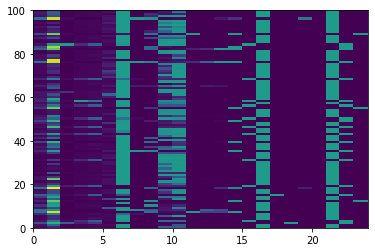

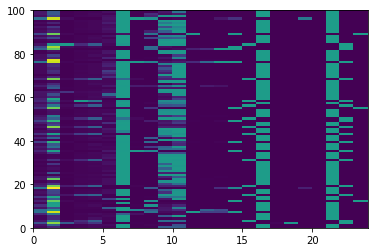

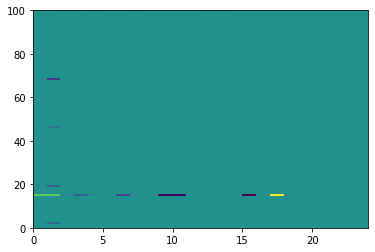

('radius', -0.6840670831982628, 0.48493787889882944, -0.011849969626599056) ('meanDist', -0.02389889575842752, 0.501819243498646, 0.00460660312045687)


In [45]:
plt.pcolor(modelDF)
plt.show()
# 
plt.pcolor(mfogModelDF)
plt.show()
# 
c = modelDF -mfogModelDF
plt.pcolor(c)
plt.show()
# 
r = c['radius']
m = c['meanDistance']
rAvg = r.sum() / r.count()
mAvg = m.sum() / m.count()
print(('radius', r.min(), r.max(), rAvg), ('meanDist', m.min(), m.max(), mAvg))

In [46]:
print(c.mean())
c.loc[c.idxmax()]

meanDistance    4.606603e-03
radius         -1.184997e-02
c0             -4.946126e-04
c1             -3.993706e-03
c2             -6.609324e-04
c3             -3.851521e-05
c4             -5.757464e-03
c5              2.833485e-06
c6              8.361278e-10
c7             -9.564077e-03
c8             -9.547266e-03
c9              5.025578e-08
c10            -2.417167e-10
c11            -4.488437e-10
c12            -3.320751e-10
c13            -9.866177e-03
c14            -2.445221e-10
c15             9.619872e-03
c16             2.463050e-04
c17             7.219056e-10
c18            -3.083923e-13
c19             1.355932e-12
c20             1.186441e-10
c21             0.000000e+00
dtype: float64


,meanDistance,radius,c0,c1,c2,c3,c4,c5,c6,c7,...,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21
15,5.018192e-01,4.849379e-01,-6.234620e-02,-4.055964e-01,-6.590630e-02,-3.968252e-03,-5.769231e-01,0.000000e+00,0.000000e+00,-9.592424e-01,...,0.000000e+00,-1.000000,0.000000e+00,1.000000,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
15,5.018192e-01,4.849379e-01,-6.234620e-02,-4.055964e-01,-6.590630e-02,-3.968252e-03,-5.769231e-01,0.000000e+00,0.000000e+00,-9.592424e-01,...,0.000000e+00,-1.000000,0.000000e+00,1.000000,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
2,-2.389890e-02,-3.464898e-01,1.175910e-02,2.139157e-03,1.219948e-03,4.442780e-05,0.000000e+00,2.073274e-04,0.000000e+00,5.282714e-04,...,0.000000e+00,0.000000,0.000000e+00,-0.024631,0.02463,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
2,-2.389890e-02,-3.464898e-01,1.175910e-02,2.139157e-03,1.219948e-03,4.442780e-05,0.000000e+00,2.073274e-04,0.000000e+00,5.282714e-04,...,0.000000e+00,0.000000,0.000000e+00,-0.024631,0.02463,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
2,-2.389890e-02,-3.464898e-01,1.175910e-02,2.139157e-03,1.219948e-03,4.442780e-05,0.000000e+00,2.073274e-04,0.000000e+00,5.282714e-04,...,0.000000e+00,0.000000,0.000000e+00,-0.024631,0.02463,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
68,-4.575372e-03,-6.840671e-01,7.507557e-05,5.698397e-04,-7.770729e-04,1.275487e-04,1.071443e-03,4.285714e-09,0.000000e+00,7.142714e-04,...,0.000000e+00,0.003571,0.000000e+00,-0.003571,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
68,-4.575372e-03,-6.840671e-01,7.507557e-05,5.698397e-04,-7.770729e-04,1.275487e-04,1.071443e-03,4.285714e-09,0.000000e+00,7.142714e-04,...,0.000000e+00,0.003571,0.000000e+00,-0.003571,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
2,-2.389890e-02,-3.464898e-01,1.175910e-02,2.139157e-03,1.219948e-03,4.442780e-05,0.000000e+00,2.073274e-04,0.000000e+00,5.282714e-04,...,0.000000e+00,0.000000,0.000000e+00,-0.024631,0.02463,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0
96,-2.403554e-08,1.762462e-07,-3.043478e-09,3.140097e-10,0.000000e+00,-4.761905e-09,0.000000e+00,0.000000e+00,4.782609e-08,0.000000e+00,...,-3.478261e-08,0.000000,0.000000e+00,0.000000,0.00000,3.478261e-08,0.0,0.000000e+00,0.000000e+00,0.0
46,-8.408692e-03,-2.403208e-01,2.594786e-04,1.098637e-03,-1.214999e-03,3.854072e-05,6.655478e-05,0.000000e+00,0.000000e+00,7.476258e-04,...,0.000000e+00,0.005474,0.000000e+00,-0.005474,0.00000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0


In [ ]:

In [ ]:
